# Effect of prominent Macroeconomic factors on the Housing Price Index in the United States

## Load Packages

In [167]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
#from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import math

## Load Data

### Variables
- Purchase only house price index: asdf
- Unemployment rate: asdf
- Consumer price index: asdf
- Inflation rate US: asdf
- Consumer sentiment: asdf
- Producer price index construction machinery manufacturing: asdf
- Average mortgage interest: asdf
- Personal income: asdf
- Moody's seasoned AAA corporate bond yield: asdf
- Home supply: asdf

## Import data

In [168]:
# define series_id
series_id_dict = {"house_pi": 'HPIPONM226S',
                 "unemp_rate": "UNRATE",
                 "CPI": "USACPIALLMINMEI",
                 "cons_sent": "UMCSENT",
                 "PI_const": "PCU333120333120",
                 "mortgage_int": "MORTGAGE30US",
                 "personal_inc": "PI",
                 "corp_yield": "AAA",
                 "home_supply": "MSACSR"}

# get data folder path
project_name = "housing-price-index-us"
raw_data_path = os.path.join(os.environ["RESEARCH_PATH"], project_name, "data", "raw")

# get filename
observation_start = "2000-01-01"
observation_end = "2022-06-30"

filename_list = []
for id in series_id_dict:
    filename_list.append(f"data_{series_id_dict[id]}_{observation_start}_to_{observation_end}.feather")


# call the function to fetch the data from FRED API
#data = pd.read_feather(os.path.join(raw_data_path, filename_list[0]))
data = pd.read_feather(os.path.join(raw_data_path, filename_list[0])).iloc[:,0:1]
    
# join all data together in a single pd.DataFrame
temp = 0
for key, value in series_id_dict.items():
    data[key] = pd.read_feather(os.path.join(raw_data_path, filename_list[temp])).iloc[:,1:]
    temp += 1

# change data type to float for all columns (but date)
for key, value in series_id_dict.items():
    data[key] = pd.to_numeric(data[key])

data['date'] = pd.to_datetime(data['date'])        

#print(data)

## EDA

### preliminary/high-level EDA

In [169]:
#print(data.head())
print('******************************************************************************************')
#print(data.shape)
print('******************************************************************************************')
#print(data.dtypes) # all floats except for 'date' which is datetime
print('******************************************************************************************')
#print(data.info())
print('******************************************************************************************')
print(data.isnull().sum()) # no null data

******************************************************************************************
******************************************************************************************
******************************************************************************************
******************************************************************************************
date            0
house_pi        0
unemp_rate      0
CPI             0
cons_sent       0
PI_const        0
mortgage_int    0
personal_inc    0
corp_yield      0
home_supply     0
dtype: int64


### some further EDA

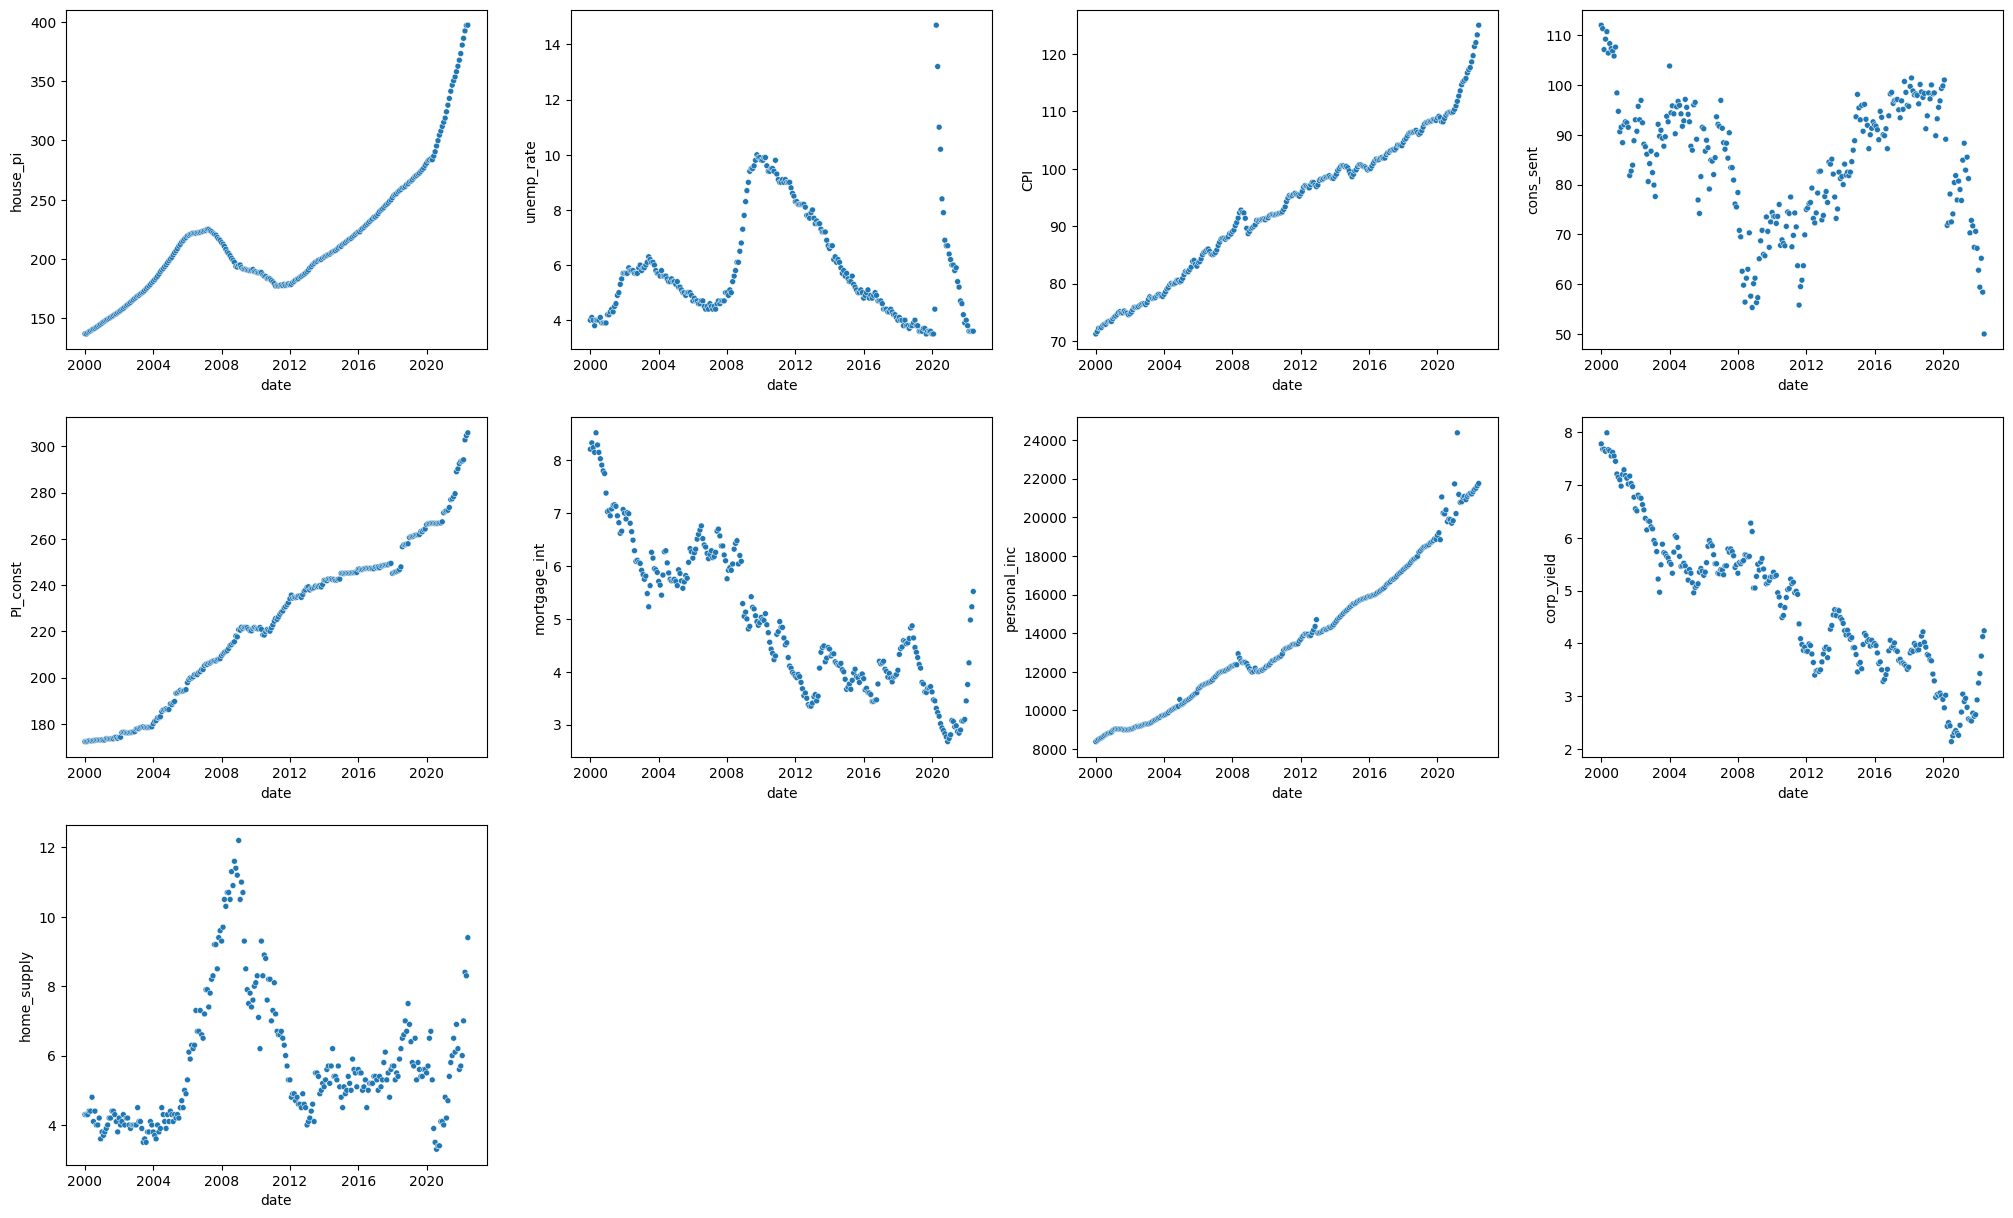

In [170]:
# plot how each variable evolves over time
cols = data.columns[1:,] # don't plot date against itself
n_rows = math.ceil(len(cols) / 4)
figsize_height = n_rows * 5
k = 1
plt.figure(figsize = (25, figsize_height))
for i in cols:
    plt.subplot(n_rows, 4, k)
    sns.scatterplot(data = data, x = data['date'], y = i, size = 5, legend = False)
    k += 1

Interpretation:
- 'house_pi' has a clearly upwards-sloping trend with a serious uptick in the years leading up to the year 2007/08. This is not surprising as we know today that in the build-up of the subprime crisis real estate prices skyrocketed before the housing price bubble burst. After a short period of price corrections up until ca. the year 2012, the prices have again risen and still are.
- 'unemp_rate' has seen upticks after every major crisis - dotcom bubble in the early 21st century, the financial crisis starting in 2008 and very recently the Corona pandemic.
- 'CPI' has steadily risen since the the beginning of the 21st century. Since and because of the corona pandemic and additionally fuelled by the on-going war in eastern Europe, we have seen major yoy increases in inflation. Central banks around the world have tried to get inflation under control by increasing interest rates which has not shown much effect up to the end of our sample time.
- 'cons_sent' paints a somewhat cyclical picture, marked by the recessions caused by the big crises in the 21st century thus far, as mentioned above.
- 'PI_const' looks, unsurprisingly, very similar to the broader 'CSI'. As such, it is also in line with our expectations.
- Up until ca. 2020, 'mortagage_int' exhibits a clear downwards-sloping trend sparked yet again by the recent crises. Since 2020, however, we observe a turnaround which is in close connection to the effort of central banks (especially the FED) to curb inflation.
- 'personal_inc' has experienced a steady upwards-sloping trend since the start date of our data set which obviously follows from the increase in inflation over the past centuries. Note, however, that naturally due to the nature of salary negotiations, the line is much smoother compared to the one of 'CPI'.
- 'corp_yield' has a very similar evolution over time as 'mortgage_int' which is not particularly surprising since for both, the prime rate has a very big impact.
- Lastly, the 'home_supply' has a slight upwards-sloping trend with a huge upwards move shortly before the subprime crisis. Notice, that while 'house_pi' started increasing rapidly after its low point, 'home_supply' had more of a slow trod before its volatilty started increasing from the year 2020 onwards.

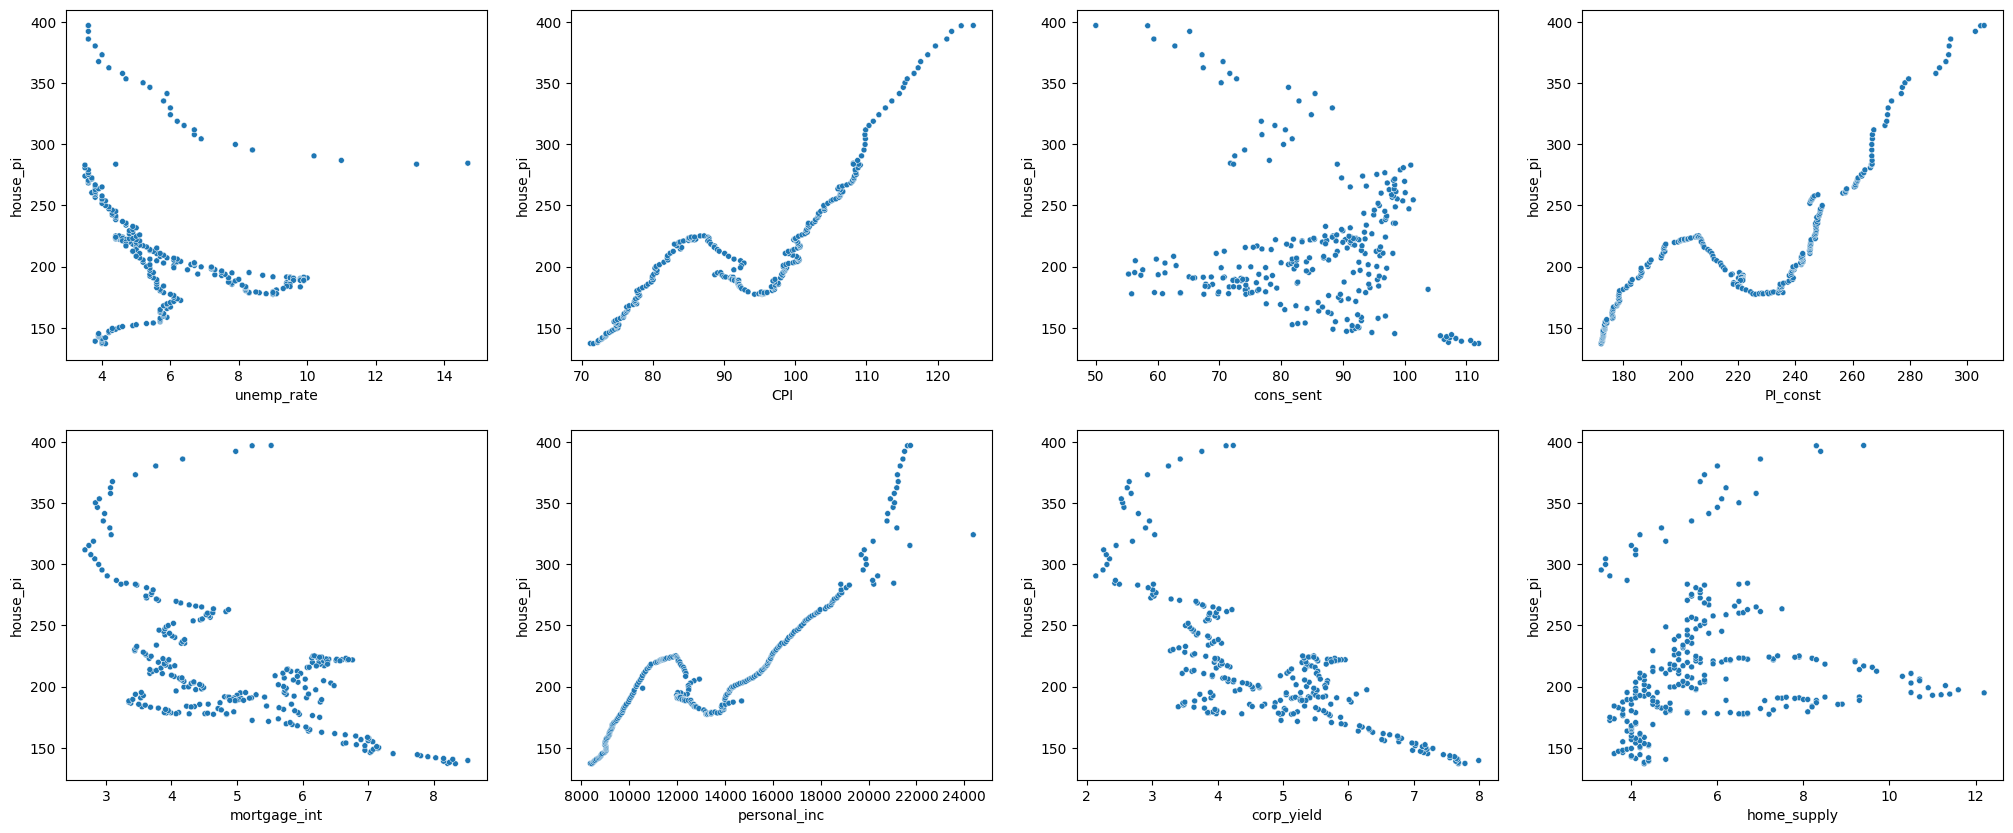

In [171]:
# plot all variables against the housing price index
cols = data.columns[2:,] # don't plot housing index against itself + see above for plot against time
n_rows = math.ceil(len(cols) / 4)
figsize_height = n_rows * 5
k = 1
plt.figure(figsize = (25, figsize_height))
for i in cols:
    plt.subplot(n_rows, 4, k)
    sns.scatterplot(data = data, x = i, y = data['house_pi'], size = 5, legend = False)
    k += 1

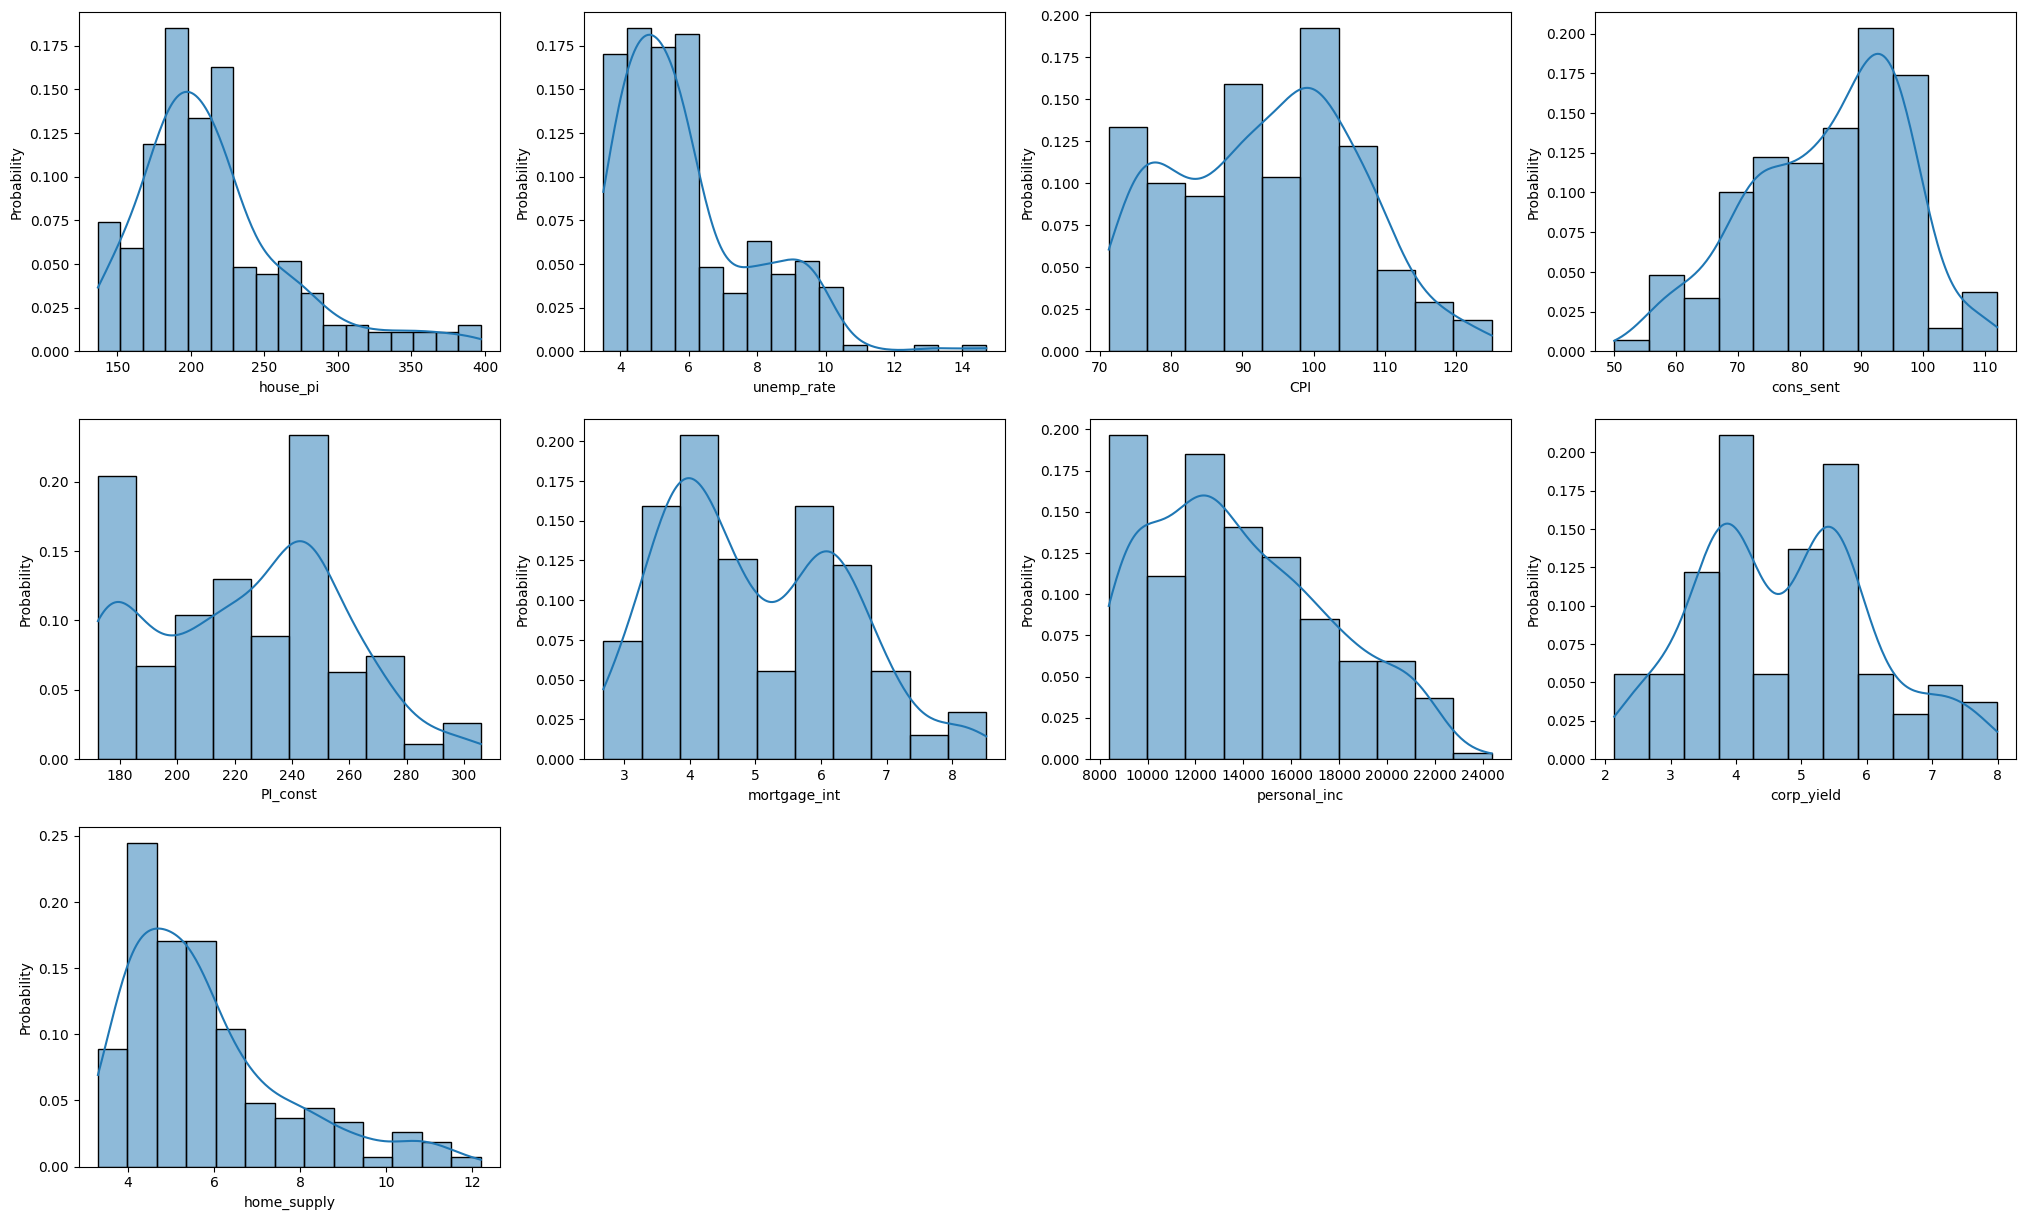

In [172]:
# distribution of the variables
cols = data.columns[1:,] #don't plot time since it's obviously uniformely distributed
n_rows = math.ceil(len(cols) / 4)
figsize_height = n_rows * 5
k = 1
plt.figure(figsize = (25, figsize_height))
for i in cols:
    plt.subplot(n_rows, 4, k)
    sns.histplot(data = data[i], stat = 'probability', kde = True)
    k += 1

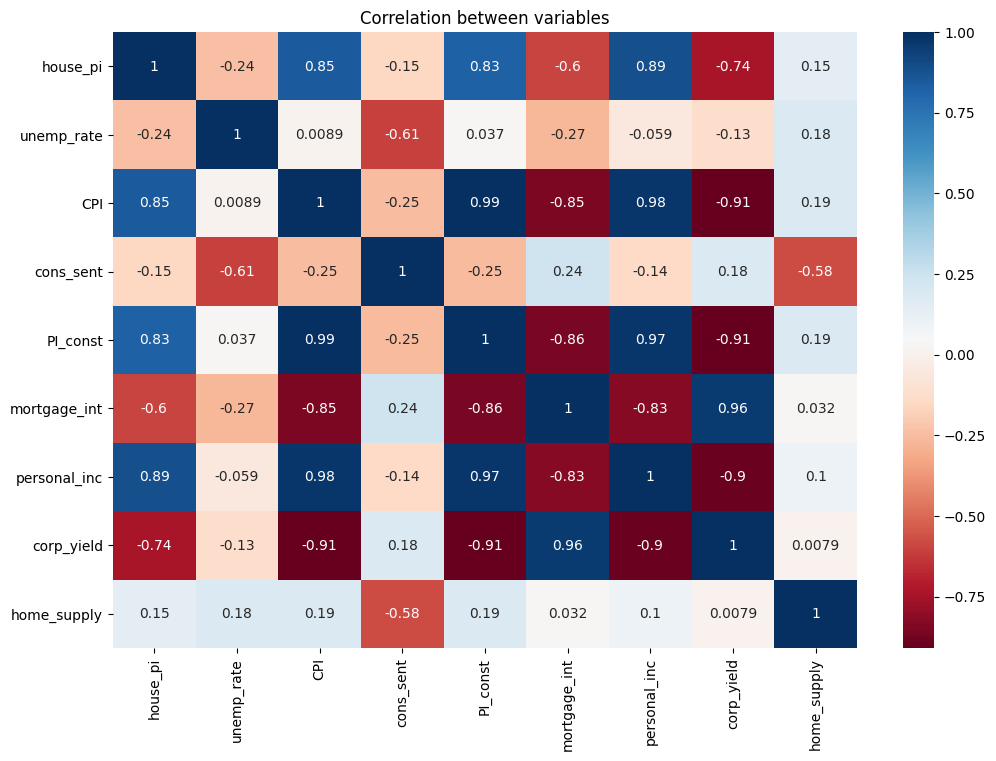

In [173]:
# correlation between the variables
plt.figure(figsize = (12, 8))
sns.heatmap(data.corr(), cmap = 'RdBu', annot = True)
plt.title('Correlation between variables')
plt.show()

## Modelling

### Splitting data into training and test set

In [174]:
data_train, data_test = train_test_split(data, train_size = 0.7, random_state = 100)

data_train_dates = data_train['date']
data_test_dates = data_test['date']

data_train = data_train.iloc[:,1:]
data_test = data_test.iloc[:,1:]

data_train.head()

,house_pi,unemp_rate,CPI,cons_sent,PI_const,mortgage_int,personal_inc,corp_yield,home_supply
55,192.15,5.4,79.952071,95.9,186.0,5.87,10107.8,5.65,4.3
22,153.82,5.5,74.846952,83.9,174.2,6.66,8997.6,6.97,4.1
200,231.64,5.0,101.861048,91.2,247.2,3.46,16207.3,3.41,5.2
11,145.13,3.9,73.412456,98.4,173.0,7.38,8874.7,7.21,3.6
15,148.70,4.4,74.635997,88.4,173.6,7.08,9033.8,7.20,3.9


In [175]:
if data_train.columns[0] != 'date':
    # initialize scaler
    scaler = MinMaxScaler()

    # reset index
    data_train_dates = data_train_dates.reset_index()['date']

    # apply scaler
    data_train = pd.DataFrame(scaler.fit_transform(data_train), columns = data.columns[1:])

    # put date column back
    data_train_test = data_train.insert(0, 'date', data_train_dates)

## divide data into dependent and independent variable(s)

In [176]:
dep_train = data_train.pop('house_pi')
indep_train = data_train

## fit the models

In [177]:
# fit the model
if indep_train.columns[0] == 'date':
    indep_train_wdate = indep_train
    indep_train.pop('date')

indep_train = sm.add_constant(indep_train)
lm = sm.OLS(dep_train, indep_train).fit()

# print  summary
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               house_pi   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     259.2
Date:                Fri, 25 Nov 2022   Prob (F-statistic):           1.68e-94
Time:                        16:33:39   Log-Likelihood:                 273.39
No. Observations:                 189   AIC:                            -528.8
Df Residuals:                     180   BIC:                            -499.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.3569      0.064      5.612   

c:\Users\Aaron\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


From the output, one would deduce that 'CPI' and 'house_supply' can be dropped from the model. This shall be tested below using ANOVA.

In [178]:
# fit second model without 'CPI' and 'home_supply'

# exclude the variables from the data set
#cpi_loc = indep_train.columns.get_loc('CPI')
#homesup_loc = indep_train.columns.get_loc('home_supply')
indep_train_model2 = indep_train.loc[:, indep_train.columns != 'CPI']
indep_train_model2 = indep_train_model2.loc[:, indep_train_model2.columns != 'home_supply']

# fit model
lm2 = sm.OLS(dep_train, indep_train_model2).fit()

# print summary
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:               house_pi   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     348.0
Date:                Fri, 25 Nov 2022   Prob (F-statistic):           6.66e-97
Time:                        16:33:39   Log-Likelihood:                 273.05
No. Observations:                 189   AIC:                            -532.1
Df Residuals:                     182   BIC:                            -509.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.3680      0.052      7.039   

Results seem to be very close, i.e., it does not matter whether we include the two additional variables or not.

In [179]:
# conduct ANOVA
anova_res = anova_lm(lm2, lm)
print(anova_res)

if indep_train_model2.columns[0] == 'const':
    indep_train_model2 = indep_train_model2.drop(['const'], axis = 1)

# calculate VIF for new model
vif = pd.DataFrame()
X = indep_train_model2
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

   df_resid       ssr  df_diff   ss_diff         F   Pr(>F)
0     182.0  0.615329      0.0       NaN       NaN      NaN
1     180.0  0.613140      2.0  0.002189  0.321245  0.72566


,Features,VIF
4,personal_inc,105.35
5,corp_yield,104.36
2,PI_const,101.82
3,mortgage_int,79.63
1,cons_sent,11.29
0,unemp_rate,3.82


Also the result from the ANOVA tells us, that it does not make much of a difference whether we use the bigger or the smaller model. Looking at the two information criteria, the smaller model is slightly better which is why we use the second model for all further computations.

However, the VIFs are rather high so we drop the variable with the highest VIF (personal income) and check for a newly fitted model without it.

In [180]:
# drop personal income
indep_train_model3 = indep_train_model2.loc[:, indep_train_model2.columns != 'personal_inc']

# retrain model
indep_train_model3 = sm.add_constant(indep_train_model3)
lm3 = sm.OLS(dep_train, indep_train_model3).fit()

# print  summary
print(lm3.summary())

# anova
anova_res2 = anova_lm(lm3, lm2)
print(anova_res2)

# VIF calculations
if indep_train_model2.columns[0] == 'const':
    indep_train_model2 = indep_train_model2.drop(['const'], axis = 1)

# calculate VIF for new model
vif = pd.DataFrame()
X = indep_train_model2
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:               house_pi   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     249.2
Date:                Fri, 25 Nov 2022   Prob (F-statistic):           1.17e-79
Time:                        16:33:39   Log-Likelihood:                 228.79
No. Observations:                 189   AIC:                            -445.6
Df Residuals:                     183   BIC:                            -426.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.4661      0.065      7.191   

c:\Users\Aaron\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,Features,VIF
4,personal_inc,105.35
5,corp_yield,104.36
2,PI_const,101.82
3,mortgage_int,79.63
1,cons_sent,11.29
0,unemp_rate,3.82
